### implementing U-Net

<p align="center">
    <img src="../images/U-net1.png" style="height :500px" alt="U-net" title="U-net"/>
    <img src="../images/U-net2.png" style="height :500px" alt="U-net" title="U-net"/>
</p>

In [45]:
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout
from keras.layers import concatenate, UpSampling2D

class U_Net(Model) : 
    def __init__(self, input_shape=(128, 128, 2)):
        super().__init__()
        # input shape must be 2 channel
        # since our data is polar-coordinated

        self.input_layer = Input(shape=input_shape)

        last_layer = self.input_layer
        concate_list = []
        filter_num = 64                     # set initial number of filters as 64
        for i in range(4) :
            conv1 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
                padding="same", name="conv-{}_1".format(i + 1)
            )(last_layer)

            conv2 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
                padding="same", name="conv-{}_2".format(i + 1)
            )(conv1)

            if i == 3 : 
                conv2 = Dropout(0.5)(conv2)
            
            max_pool = MaxPooling2D(pool_size=(2, 2))(conv2)
            
            filter_num *= 2
            last_layer = max_pool
            concate_list.insert(0, conv2)
        
        conv5_1 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
            padding="same", name="conv-5_1"
        )(last_layer)
        conv5_2 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
            padding="same", name="conv-5_2"
        )(conv5_1)
        drop5 = Dropout(0.5)(conv5_2)

        last_layer = drop5

        for i, prev_layer in enumerate(concate_list) : 
            print(i)
            filter_num /= 2
            up_conv1 = UpSampling2D(size=(2, 2), name="upsample-{}".format(4 - i))(last_layer)
            up_conv2 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
                padding="same", name="upconv-{}_1".format(4 - i)
            )(up_conv1)
            
            merge_layer = concatenate(inputs=[up_conv2, prev_layer], axis=3, name="merge-{}".format(4 - i))

            up_conv3 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
                padding="same", name="upconv-{}_2".format(4 - i)
            )(merge_layer)
            up_conv4 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
                padding="same", name="upconv-{}_3".format(4 - i)
            )(up_conv3)
            last_layer = up_conv4

        conv_restore = Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same", name="conv_restore")(last_layer)
        self.output_layer = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), activation="relu", padding="same", name="conv-output")(conv_restore)
        self.__model__ = Model(inputs=[self.input_layer], outputs=[self.output_layer])
    
    def call(self, input_shape=(128,128,2)):
        self.input_layer = Input(shape=input_shape)

        last_layer = self.input_layer
        concate_list = []
        filter_num = 64                     # set initial number of filters as 64
        for i in range(4) :
            conv1 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
                padding="same", name="conv-{}_1".format(i + 1)
            )(last_layer)

            conv2 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
                padding="same", name="conv-{}_2".format(i + 1)
            )(conv1)

            if i == 3 : 
                conv2 = Dropout(0.5)(conv2)
            
            max_pool = MaxPooling2D(pool_size=(2, 2))(conv2)
            
            filter_num *= 2
            last_layer = max_pool
            concate_list.insert(0, conv2)
        
        conv5_1 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
            padding="same", name="conv-5_1"
        )(last_layer)
        conv5_2 = Conv2D(
            filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
            padding="same", name="conv-5_2"
        )(conv5_1)
        drop5 = Dropout(0.5)(conv5_2)

        last_layer = drop5

        for i, prev_layer in enumerate(concate_list) : 
            print(i)
            filter_num /= 2
            up_conv1 = UpSampling2D(size=(2, 2), name="upsample-{}".format(4 - i))(last_layer)
            up_conv2 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
                padding="same", name="upconv-{}_1".format(4 - i)
            )(up_conv1)
            
            merge_layer = concatenate(inputs=[up_conv2, prev_layer], axis=3, name="merge-{}".format(4 - i))

            up_conv3 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
                padding="same", name="upconv-{}_2".format(4 - i)
            )(merge_layer)
            up_conv4 = Conv2D(
                filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
                padding="same", name="upconv-{}_3".format(4 - i)
            )(up_conv3)
            last_layer = up_conv4

        conv_restore = Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same", name="conv_restore")(last_layer)
        self.output_layer = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), activation="relu", padding="same", name="conv-output")(conv_restore)

        return self.output_layer

In [13]:
input_shape = (128, 128, 1)
input_layer = Input(shape=input_shape)

last_layer = input_layer
concate_list = []
filter_num = 64                     # set initial number of filters as 64
for i in range(4) :
    conv1 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
        padding="same", name="conv-{}_1".format(i + 1)
    )(last_layer)

    conv2 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu",
        padding="same", name="conv-{}_2".format(i + 1)
    )(conv1)

    if i == 3 : 
        conv2 = Dropout(0.5)(conv2)
    
    max_pool = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    filter_num *= 2
    last_layer = max_pool
    concate_list.insert(0, conv2)

conv5_1 = Conv2D(
    filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
    padding="same", name="conv-5_1"
)(last_layer)
conv5_2 = Conv2D(
    filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
    padding="same", name="conv-5_2"
)(conv5_1)
drop5 = Dropout(0.5)(conv5_2)

last_layer = drop5

for i, prev_layer in enumerate(concate_list) : 
    filter_num /= 2
    up_conv1 = UpSampling2D(size=(2, 2), name="upsample-{}".format(4 - i))(last_layer)
    up_conv2 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
        padding="same", name="upconv-{}_1".format(4 - i)
    )(up_conv1)
    
    merge_layer = concatenate(inputs=[up_conv2, prev_layer], axis=3, name="merge-{}".format(4 - i))

    up_conv3 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
        padding="same", name="upconv-{}_2".format(4 - i)
    )(merge_layer)
    up_conv4 = Conv2D(
        filters=filter_num, kernel_size=(3, 3), strides=(1, 1), activation="relu", 
        padding="same", name="upconv-{}_3".format(4 - i)
    )(up_conv3)
    last_layer = up_conv4

conv_restore = Conv2D(filters=2, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same", name="conv_restore")(last_layer)
output_layer = Conv2D(filters=1, kernel_size=(1, 1), strides=(1, 1), activation="relu", padding="same", name="conv-output")(conv_restore)

model = Model(inputs=[input_layer], outputs=[output_layer])
model.summary()

0
1
2
3
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv-1_1 (Conv2D)              (None, 128, 128, 64  640         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv-1_2 (Conv2D)              (None, 128, 128, 64  36928       ['conv-1_1[0][0]']               
                                )                                                   

In [46]:
temp = U_Net(input_shape=(128, 128, 1))

0
1
2
3


In [48]:
temp.__model__.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv-1_1 (Conv2D)              (None, 128, 128, 64  640         ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 conv-1_2 (Conv2D)              (None, 128, 128, 64  36928       ['conv-1_1[0][0]']               
                                )                                                           

hi
Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  6464      
                                                                 
 dense_1 (Dense)             multiple                  650       
                                                                 
 dense_2 (Dense)             multiple                  704       
                                                                 
 dense_3 (Dense)             multiple                  650       
                                                                 
Total params: 8,468
Trainable params: 8,468
Non-trainable params: 0
_________________________________________________________________


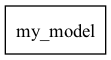

In [59]:
import tensorflow as tf
from keras.backend import clear_session

clear_session()

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')
        self.dense3 = tf.keras.layers.Dense(64, activation='relu')
        self.dense4 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        print('hi')
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

model = MyModel()

# Create some dummy input data (replace this with your actual data)
dummy_data = tf.ones((1, 100))  # Assuming an input shape of (100,)

# Pass the dummy data through the model to build it
_ = model(dummy_data)

# Now print the summary
model.summary()

from keras.utils import plot_model

plot_model(model)


In [60]:
import tensorflow as tf

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

    def summary(self, sample_input):
        x = tf.keras.Input(shape=sample_input.shape[1:])
        tf.keras.Model(inputs=x, outputs=self.call(x)).summary()

model = MyModel()

# Create a sample input with the desired shape
sample_input = tf.ones((1, 100))  # Assuming an input shape of (100,)

# Print the summary with the sample input
model.summary(sample_input)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 64)                6464      
                                                                 
 dense_5 (Dense)             (None, 10)                650       
                                                                 
Total params: 7,114
Trainable params: 7,114
Non-trainable params: 0
_________________________________________________________________


In [61]:
import tensorflow as tf

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(64, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')
        self._model_initialized = False

    def build_model(self, sample_input):
        x = tf.keras.Input(shape=sample_input.shape[1:])
        tf.keras.Model(inputs=x, outputs=self.call(x)).summary()
        self._model_initialized = True

    def call(self, inputs):
        x = self.dense1(inputs)
        return self.dense2(x)

    def summary(self, sample_input=None):
        if not self._model_initialized:
            if sample_input is None:
                raise ValueError("Please provide a sample_input for model initialization.")
            self.build_model(sample_input)
        else:
            super(MyModel, self).summary()

model = MyModel()

# Create a sample input with the desired shape
sample_input = tf.ones((1, 100))  # Assuming an input shape of (100,)

# Print the summary with the sample input
model.summary(sample_input)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_6 (Dense)             (None, 64)                6464      
                                                                 
 dense_7 (Dense)             (None, 10)                650       
                                                                 
Total params: 7,114
Trainable params: 7,114
Non-trainable params: 0
_________________________________________________________________
